In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Flatten
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, zero_one_loss

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

Load dataset and check it if it have non value.

In [ ]:
data_path = 'C:\\Users\\mooha\\jupyter\\NLP Project\\TextClassification\\dataset.csv'
data = pd.read_csv(data_path, encoding = 'ISO-8859-1')

print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7570 entries, 0 to 7569
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Text        7570 non-null   object
 1   CancerType  7570 non-null   object
dtypes: object(2)
memory usage: 118.4+ KB
None


,Text,CancerType
0,Thyroid surgery in children in a single insti...,Thyroid_Cancer
1,""" The adopted strategy was the same as that us...",Thyroid_Cancer
2,coronary arterybypass grafting thrombosis ï¬b...,Thyroid_Cancer
3,Solitary plasmacytoma SP of the skull is an u...,Thyroid_Cancer
4,This study aimed to investigate serum matrix ...,Thyroid_Cancer


This step to know number of words in each line of dataset.

In [ ]:
data['Words Count'] = ''
maxLine = 0

for i in range(len(data)):
    text = data['Text'][i].split() 
    data['Words Count'][i] = len(text)
    
    if len(text) > maxLine:
        maxLine = len(text)
           
print(maxLine)

5259


This step to know number of Letters in each line of dataset.

In [ ]:
data['Letters Count'] = data['Text'].apply(len)
print('Max Letters Count document: ', data['Letters Count'].max())
print('index: ', data['Letters Count'].idxmax())

data.head()

Max Letters Count document:  32712
index:  10


,Text,CancerType,Words Count,Letters Count
0,Thyroid surgery in children in a single insti...,Thyroid_Cancer,2871,20707
1,""" The adopted strategy was the same as that us...",Thyroid_Cancer,2494,17018
2,coronary arterybypass grafting thrombosis ï¬b...,Thyroid_Cancer,2954,21622
3,Solitary plasmacytoma SP of the skull is an u...,Thyroid_Cancer,1880,13860
4,This study aimed to investigate serum matrix ...,Thyroid_Cancer,3037,23696


This step is to make sure that the data is balanced.

['Thyroid_Cancer' 'Colon_Cancer' 'Lung_Cancer']


<Axes: xlabel='CancerType', ylabel='count'>

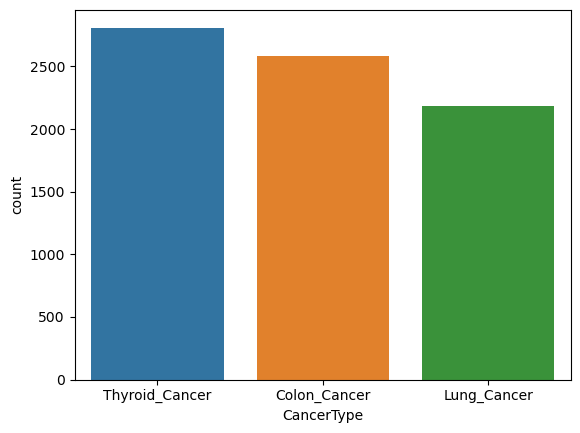

In [ ]:
print(data['CancerType'].unique())
sb.countplot(x = data['CancerType'])

In [ ]:
# nltk.download()
stopwords = stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
print(data['Text'][0], '\n')
print(len((data['Text'][0].split())))

Thyroid surgery in  children in a single institution from Osama Ibrahim Almosallama Ali Aseerib Ahmed Alhumaida Ali S AlZahranic Saif Alsobhib Saud AlShanafeybFrom the  aDepartment of Surgery College of Medicine Qassim University Buraidah Al Qassim Saudi Arabia  bDepartment of Surgery King Faisal Specialist Hospital and Research Center Riyadh Saudi Arabia cDepartment of Medicine King Faisal Specialist Hospital and Research Center Riyadh Saudi Arabia Correspondence   Dr  Osama Ibrahim  Almosallam  Department of  Surgery  College  of  Medicine Qassim  University  PO  Box   Buraidah  Al  Qassim   Saudi  Arabia  osama_iaahotmailcom ORCID orcid0000000290367564        Citation  Almosallam OI Aseeri A Alhumaid A AlZahrani AS Alsobhi S AlShanafey S Thyroid surgery in  children  in  a  single  institution  from   Ann  Saudi  Med         Received January  Accepted May  Published August  Copyright Copyright   Annals of Saudi Medicine Saudi Arabia This is an   access  under the Creative Commons At

Preprocessing: We removed all stopwords, We removed words of length equal or less than 2, We have used Regular Expression to made all data sets without numbers or strange symbols and make them in lowercase letters, We use Lemmtizations to make every word in base dictionary form to prepare data before feeding them into the network.

In [ ]:
lemmtizer = WordNetLemmatizer()

corpus = []
for i in range(len(data)):
    text = re.sub('[^a-zA-Z]', ' ', data['Text'][i]) #012435789 !@#$%^&
    text = text.lower() 
    tokens = word_tokenize(text) 
    
    words = []
    for word in tokens:
        if word not in stopwords: 
            if len(word) <= 2:
                continue
                
            word = lemmtizer.lemmatize(word, 'n') # playing
            word = lemmtizer.lemmatize(word, 'v') # play
            word = lemmtizer.lemmatize(word, 'a') # play
            word = lemmtizer.lemmatize(word, 'r') # play
            words.append(word)
            
    text = ' '.join(words)
    corpus.append(text)

print(corpus[0], '\n')
print(len(corpus[0].split()), '\n')
print(len(corpus))

thyroid surgery child single institution osama ibrahim almosallama ali aseerib ahmed alhumaida ali alzahranic saif alsobhib saud alshanafeybfrom adepartment surgery college medicine qassim university buraidah qassim saudi arabia bdepartment surgery king faisal specialist hospital research center riyadh saudi arabia cdepartment medicine king faisal specialist hospital research center riyadh saudi arabia correspondence osama ibrahim almosallam department surgery college medicine qassim university box buraidah qassim saudi arabia osama iaahotmailcom orcid orcid citation almosallam aseeri alhumaid alzahrani alsobhi alshanafey thyroid surgery child single institution ann saudi med receive january accept may publish august copyright copyright annals saudi medicine saudi arabia access creative common attributionnoncommercialnoderivatives international license byncnd detail access httpcreativecommons licensesbyncnd fund nonebackground data thyroid surgery child scarceobjective analyze outcome 

In [ ]:
# word = 'better'

# word = lemmtizer.lemmatize(word, 'n')
# print(word)

# word = lemmtizer.lemmatize(word, 'v')
# print(word)

# word = lemmtizer.lemmatize(word, 'a')
# print(word)

# word = lemmtizer.lemmatize(word, 'r')
# print(word)

better
better
good
good


We have made the most frequent words that will feed to embedding layer as input dimential and we convert all words into numbers to prepare X, y for splitting them in next step.

In [ ]:
max_words = 25000 #10000 - 50000
tokenizer = Tokenizer(num_words = max_words) 
tokenizer.fit_on_texts(corpus)
X = tokenizer.texts_to_sequences(corpus)

le = LabelEncoder()
data['CancerType'] = le.fit_transform(data['CancerType'])
y = data['CancerType']

print(X[0], '\n')
print(y[0])

data.head()

[152, 116, 748, 377, 2508, 24466, 9738, 3070, 7163, 3070, 15063, 116, 1166, 175, 15264, 103, 15264, 2840, 5230, 12687, 116, 6340, 11744, 2808, 137, 72, 293, 13856, 2840, 5230, 24016, 175, 6340, 11744, 2808, 137, 72, 293, 13856, 2840, 5230, 1107, 24466, 9738, 184, 116, 1166, 175, 15264, 103, 1509, 15264, 2840, 5230, 24466, 4699, 4699, 5417, 152, 116, 748, 377, 2508, 1266, 2840, 304, 214, 1522, 735, 36, 239, 392, 892, 892, 8365, 2840, 175, 2840, 5230, 278, 141, 76, 9739, 407, 369, 4454, 528, 278, 1152, 10, 152, 116, 748, 133, 166, 10, 152, 116, 1763, 120, 465, 5793, 95, 174, 80, 371, 1287, 30, 10, 3, 49, 812, 152, 116, 393, 2835, 10, 166, 132, 1330, 3309, 152, 611, 529, 959, 2330, 3963, 1426, 16, 179, 17, 3, 500, 3309, 511, 354, 104, 71, 1832, 49, 41, 205, 2095, 2965, 66, 507, 483, 201, 3, 4264, 2529, 4667, 7004, 329, 661, 3114, 33, 3, 427, 2, 1320, 3, 687, 1929, 299, 217, 85, 1043, 85, 18, 511, 22, 105, 3309, 17279, 3723, 10329, 3309, 24467, 3, 203, 7778, 4790, 7485, 1444, 4197, 1845, 4

,Text,CancerType,Words Count,Letters Count
0,Thyroid surgery in children in a single insti...,2,2871,20707
1,""" The adopted strategy was the same as that us...",2,2494,17018
2,coronary arterybypass grafting thrombosis ï¬b...,2,2954,21622
3,Solitary plasmacytoma SP of the skull is an u...,2,1880,13860
4,This study aimed to investigate serum matrix ...,2,3037,23696


In [ ]:
# counter = 0
# for i in range(len(X)):
#     if (len(X[i])) > 2500:
#         counter += 1

# vocab_size = len(tokenizer.word_index) + 1
# print(counter)
# print(vocab_size)

2215
160967


We have splitted the data into 80% training data, 20% testing data.
We have made all words contain 1,000 words of fixed length and padding 'post' them by zeros.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle = True)

max_Text_length = 1000

X_train = sequence.pad_sequences(X_train, maxlen = max_Text_length, padding = 'post')
X_test = sequence.pad_sequences(X_test, maxlen = max_Text_length, padding = 'post')

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, '\n')
print((X_train[0]))

(6056, 1000) (6056,) (1514, 1000) (1514,) 

[  799 17672  9865    38  7851 15497   346  2743    17   346    11  1047
   138   378   826    72 10241    12   709 10241   133 12870    17   183
    99    44    62     2 15303    49  3664     4   152   389    87     3
   259   231  2772   247    67  2715   558   349   152  9867     2  1014
  1020     5  1383   210   210   263  6618  2662    97  1126    62     2
   817     9    43   180   463  7239    15    23    44    62     2  8522
   210 17671  2304    26 15557  2158    99    44    62     2    69  1020
   178     5   210  1889  2662   210    96   152    78    50  1889  2662
    41  2772    44  1416   318   241   349    59 20508 20509 15557    37
   111   108  2772   144   165    62     2    43     6  1024    14   173
  1463    39   315     1   396   157  5965   435    55  1068   194  8504
  2662    62   105     5    22  1068    17     9     3 17671   124    44
    62    70   826   109     5   943    11    26 10241    72    36 10241
    72 

We have used Embedding layer to understand the meaning of speech and make relationships between words and each otherز

LSTM Architecture: The LSTM architecture is defined and consists of 128 Units  followed by two layers, and we add batch normalization and dropout (type of regularization) to avoid overfitting.

Training: The LSTM model is trained on a dataset of 6056 text belonging to three different types of Cancer 
(Thyroid, Lung, Colon).

Testing: The final step is testing the model on new unseen 1514 text to classify them into one of the three Cancer types.

Results: Finally, we get the Accuracy = 96.24% 

In [ ]:
model = Sequential()

model.add(Embedding(max_words, 100, input_length = max_Text_length)) 
model.add(LSTM(128)) 
# model.add(BatchNormalization()) 
model.add(Dropout(0.25))

# model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 5)

y_pred = model.predict(X_test)

model.summary()

Epoch 1/5
95/95 [==============================] - 86s 881ms/step - loss: 0.7362 - accuracy: 0.6636 - val_loss: 0.3032 - val_accuracy: 0.9016
Epoch 2/5
95/95 [==============================] - 85s 895ms/step - loss: 0.1712 - accuracy: 0.9548 - val_loss: 0.1312 - val_accuracy: 0.9624
Epoch 3/5
95/95 [==============================] - 85s 897ms/step - loss: 0.1325 - accuracy: 0.9607 - val_loss: 0.1172 - val_accuracy: 0.9637
Epoch 4/5
95/95 [==============================] - 86s 905ms/step - loss: 0.1191 - accuracy: 0.9600 - val_loss: 0.1146 - val_accuracy: 0.9584
Epoch 5/5
48/48 [==============================] - 12s 236ms/step
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 1000, 100)         2500000   
                                                                 
 lstm_42 (LSTM)              (None, 128)               117248    
             

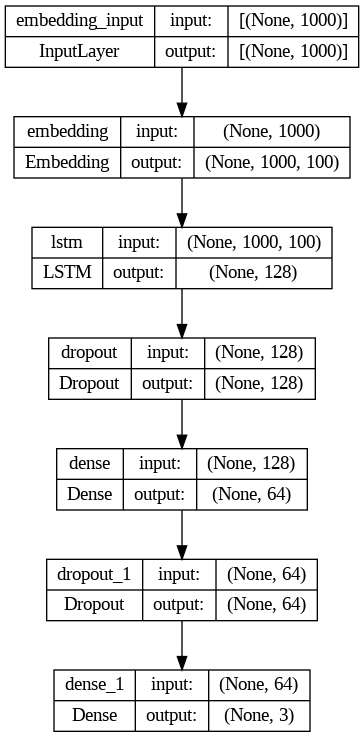

In [2]:
plot_model(model, show_shapes = True)

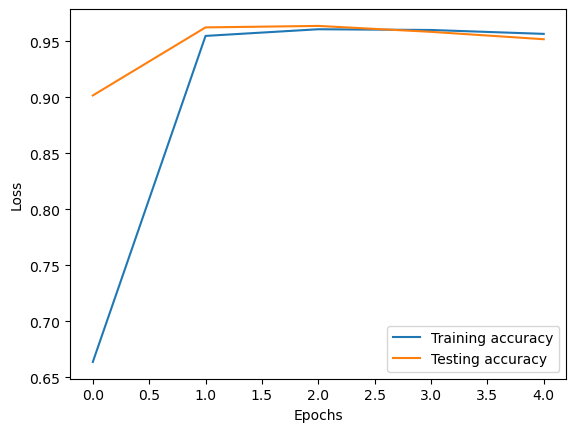

In [ ]:
plt.plot(history.history['accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_accuracy'], label = 'Testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

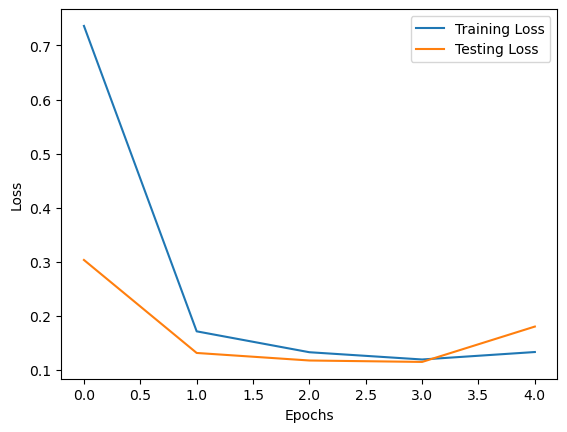

In [ ]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

This step to calculate confusion matrix and zero one loss.

In [ ]:
print(list(y_test[:25]), '\n')
print(y_pred[:25], '\n')

predict = []
for i in range(len(y_pred)):
  predict.append(np.argmax(y_pred[i]))

print(predict[:25], '\n')

cm = confusion_matrix(y_test, predict)
print(cm, '\n')

zol = zero_one_loss(y_test, predict, normalize = False)
print(zol)

[0, 2, 0, 2, 0, 2, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 1, 1, 2, 0, 0, 1, 1] 

[[9.9894506e-01 3.2296998e-04 7.3197135e-04]
 [4.9128203e-04 5.7007677e-05 9.9945176e-01]
 [9.9801397e-01 8.9317275e-04 1.0929229e-03]
 [3.8441201e-04 1.8329845e-05 9.9959725e-01]
 [9.9473286e-01 2.4400235e-03 2.8270842e-03]
 [5.9539707e-05 6.7283850e-06 9.9993366e-01]
 [9.9598283e-01 1.8804307e-03 2.1368265e-03]
 [8.9401484e-02 8.4816349e-01 6.2435139e-02]
 [9.7557622e-01 1.0099298e-02 1.4324554e-02]
 [9.9806678e-01 3.9313620e-04 1.5400723e-03]
 [5.6553161e-01 3.4589700e-02 3.9987865e-01]
 [9.8087972e-01 4.3146997e-03 1.4805545e-02]
 [1.5502495e-01 5.2146351e-01 3.2351160e-01]
 [8.9401484e-02 8.4816349e-01 6.2435139e-02]
 [8.9401484e-02 8.4816349e-01 6.2435139e-02]
 [1.3415182e-01 7.7292037e-01 9.2927828e-02]
 [1.7313565e-03 9.3797207e-05 9.9817485e-01]
 [8.9401484e-02 8.4816349e-01 6.2435139e-02]
 [1.3757163e-01 7.2771871e-01 1.3470955e-01]
 [8.9401484e-02 8.4816349e-01 6.2435139e-02]
 [7.3455967e-04 4.8458

<Figure size 500x500 with 0 Axes>

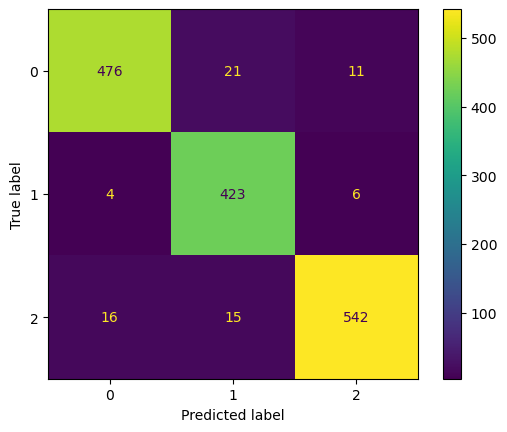

In [ ]:
plt.figure(figsize = (5,5))
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [ ]:
test_text = '''This study was performed to explore the effective management of bleeding associated with
radiofrequency ablation RFA of benign thyroid nodulesMethods Thirtyfive patients with benign thyroid
nodules who were treated with ultrasoundguided RFA from July  to December  at the Third Affiliated Hospital of Sun YatsenUniversity were retrospectively reviewed The technique efficacy bleeding and other complications were assessed during the followup periodResults The mean technique efficacy was 06 at  month and 06 at months after the procedure One case of an intranodular haematoma and two cases of voicechange  month were observed All patients recovered with corresponding treatmentConclusion Although the incidence of haemorrhage is low serious haematomas are lifethreatening Therefore having a comprehensive understanding of the potential complicationsan accurate clinical strategy and adequate technical skills may prevent or help to properly managethese complicationsKeywordsRadiofrequency ablation benign thyroid nodules haemorrhage management haematomaultrasoundDate received  January  accepted  June 1Department of Medical Ultrasound The Third AffiliatedHospital of Sun Yatsen University Guangzhou China2General Surgery Department The Third AffiliatedHospital of Sun Yatsen University Guangzhou ChinaThese authors contributed equally to this workCorresponding authorsBo Liu General Surgery Department The Third AffiliatedHospital of Sun Yatsen University  Tianhe RoadGuangzhou City Guangdong Province China Jie RenDepartment of Medical Ultrasound The Third AffiliatedHospital of Sun Yatsen University  Tianhe RoadGuangzhou City Guangdong Province ChinaEmails renjieguangzhou126com liubojake126comCreative Commons Non Commercial CC BYNC This  is distributed under the terms of the CreativeCommons AttributionNonCommercial  License creativecommonslicensesbync40 which permitsnoncommercial use reproduction and distribution of the work without further permission provided the original work is attributedas specified on the SAGE and   Access pages ussagepubcomenusnam accessatsage 0cIntroductionAssociationfor AdultThyroid nodules are extremely commonand the associated morbidity rate rangesfrom  to  according to highresolution ultrasound US ï¬ndings12Mostthyroid nodules are benign andrequire no intervention other than clinicalfollowup According to the  AmericanThyroidManagementGuidelinesPatients withThyroid Nodulesand DifferentiatedThyroid Cancer thyroidstimulating hormone suppression therapy for benign thyroid nodules BTNs is not recommendedbecause the potential harm outweighs thebeneï¬t3 Radioiodine therapy was historically an effective treatment for thyroid hotnodules and a possible alternative to surgery Howeverthis technique has beenproven to have uncertain efï¬cacy andsome adverse effects such as hypothyroidrecurrence4“ Surgery may beism orconsideredgrowing BTNs withpressurerelated symptoms neck discomfort cosmetic concerns or decreased quality of life3 At present partialtotal thyroidsurgery is considered the gold standardtreatment Surgeryassociated withnumerous complications such as nerveinjury anaesthesiarelated problemslonghospital stays conspicuous scars haemorrhage and lesions ofthe parathyroidglands78 In addition hypothyroidism isinevitable after totalthyroidectomy andrequires lifelong hormone supplementationHenceincreasingly minimally invasivetherapeutic strategies are currently used totreat BTNs In most cases several thermalablation techniques such as laser ablationmicrowave ablation radiofrequency ablation RFA and highintensity focused UShave been shown to be effective in BTNsAmong these thermal ablation techniquesRFA is the most widely applied910forisRFA of thyroid diseases ï¬rst reported in“ is considered efï¬cacious and safeJournal of International Medical Researchfor treatment of BTNs1415 To date no lifethreatening complications related to RFAhave been reported Howeverseveralcases of haemorrhagerelated to ï¬neneedle aspiration FNA or core needlebiopsy CNB have been reported16“Although a microinvasive procedure suchas FNA can result in massive uncontrolledbleeding resulting in upper airway respiratoryuncontrolledbleeding is a rare but lifethreatening complication of RFA Thus management ofbleeding associated with RFA of BTNs isof vitalimportance This study was performed to explore the effective managementof bleeding associated with RFA of BTNsobstructionsuchMaterials and methodsofThis study was approved by the EthicsCommitteethe Third Afï¬liatedHospital of Sun Yatsen University andwritten informed consent was obtainedfrom all patients prior to the performanceof USguided FNA or CNB and RFA Therequirement to obtain informed consent forpublication was waived because of the retrospective nature of the studyPatientsAll consecutive patients who underwentRFA of BTNs at our institution from July to December  were analysed Thefollowing inclusion criteria were appliedconï¬rmation of benignancyBethesdaClass II by FNA cytology or CNB complaints of pressure symptoms compressivesymptoms neck discomfort orforeignbody sensation or cosmetic problems a2cm maximum diameter of the indexnodule anxiety about a malignancy unsuitability for surgery or unwillingness toundergo surgery and a normal serum thyrotropin concentration normal completeblood counts and normal blood coagulation test results The exclusion criteria 0cHu et alwere nodules showing malignant featuresie taller than wide spiculated marginmarked hypoechoic appearance or microcalciï¬cations on US imaging19 abnormalthyroid function performance of othertreatments for the thyroid nodules within months before the procedure pregnancyand age of  years For the presentstudy only patients with 15 months offollowup after the procedure were included Thirtyï¬ve patients met the inclusioncriteriaPretreatment assessmentBefore the procedure conventional USï¬ndings USguidedFNA ï¬ndingscontrastenhanced US CEUS ï¬ndingsand laboratory and clinical results wereevaluated Two radiologists TW and JR with  and  years of thyroid US experiencerespectively performed the USUSguided FNA and CEUS examinationsusing a Logiq E9 US device GE MedicalSystems Milwaukee WI USA equippedwithtransducerwith a MHzfrequency range “ MHz The USexamination included characterisation ofthe location shape size margins solidcystic proportions echogenicity calciï¬cation status and internal vascularity ofeach nodulefrequency ofan ML615centrelinearLaboratory tests included the levels ofthyroidstimulating hormone free triiodothyronine free thyroxin and thyrotropina complete blood cell count and a coagulation test prothrombin time and activatedpartial thromboplastin time The nodulevolume was calculated using the followingvolume¼ length 02 width 02equationdepth 02 In addition all patientsunderwent vocal cord function assessmentsby an experienced laryngologist before theablation procedure Atenrolment allpatients were asked to rate their pressuresymptoms on a 10cm visual analoguescale grade “ cm and the cosmeticgrading score was assessed by the physicianas described in the consensus statement20Procedures and equipmentpreventsignificantAll RFA procedures were performed by oneradiologist JR with  years of experienceperforming RFA in an outpatient clinic Weused an RF generator VIVA RF SystemVR STARmed Gyeonggisi South Korea andan internally cooled 18gauge 70mmlength  or 10mm activetip electrodeStar RF ElectrodeVR  STARmed Localanaesthesia with  lidocaine was appliedto the puncture site The hydrodissectiontechnique was used under US guidance glucose and norepinephrine weremixed and injected into the surroundingthyroid capsule which provided a safe distance between the needle tip and adjacentcritical structures During the procedurewe paid special attention to the preservation of surrounding important structurestocomplicationsTherefore two essential techniques werethe transisthmic approach andappliedtechnique2122 Ablationthe movingshotwas suspended when the index nodule wascovered by hyperechoic zones The technique efï¬cacy TE was then evaluated byCEUS at  to  minutes after RFA untilthedisappearedTechnicalthechange of an entire nodule to a noenhancement zone on realtime CEUSFor nodules with an enhancement zonean additional ablation was performed todestroy the nodule as much as possibleComplications were monitored immediatelyafter the procedure and during the followup period Major and minor complicationsand adverse effects were deï¬ned accordingto the criteria established by the Society ofInterventional Radiology2324success was deï¬ned ashyperechoiczones 0cJournal of International Medical ResearchFollowup evaluationatandperformedserum thyroidAny speciï¬c complaints or concerns wererecorded for  month Postproceduralfollowup wasand months after treatment At each followup visit a US examination CEUS examinationhormonemeasurements were performed pressuresymptoms and the cosmetic grading scorewere evaluated and the volume ofthetreated nodule was calculated The TE wascalculated using the following equationTE¼ ï¬nal nodule volumeinitial nodule volume 02 Statistical analysisstatistical analyses were performedAllusing SPSS software version  IBMCorp Armonk NY USA Continuousvariables are expressed as mean 06 standarddeviation Quantitative data for volumeand TE were analysed using a pairedttest A P value of 14 was consideredstatistically significantResultsThe patients™ characteristics are summarised in Table  Thirtyï¬ve patients underwent RFA including  male and  femalepatients mean age  years The meanlargest BTN dimension was 06  mmrange “ mm and the mean BTNvolume was 06  mL Twentytwototal complications  minor and  majorcomplications were observed among thetreated patients None of these complications was lifethreatening and all occurredwithout sequelaeNodule volumeAfter treatment the overall volume of thesignificantly decreased 06nodules 06  mL at mL at month and 06  mL at  monthsbaselineTable  Patients™ baseline characteristics n¼ Characteristics 06 06 06 06 06 06 06 06 Age at treatment yearsMalefemale ratioBody weight kgBody height cmBody mass index kgm2Symptom score “Cosmetic score “Cosmetic score of Cosmetic score of Cosmetic score of Preablation serum FT4 level pmolLPreablation serum TSH level mIULIndex nodule on ultrasoundRight sideLeft sideLargest dimension mm to  to 15Data are presented as mean 06 standard deviation ornumber of patientsFT4 free thyroxin TSH thyroidstimulating hormoneP   and the TE was 06 at  month and 06  at months P   Table  Figure shows the shrinkage of the nodules at and  months after the procedure comparedwith baseline no hypoechoic blood supplywas observed within the area ofthenodulesBleeding complicationsTwelve patients developed bleeding complicationsincluding a perithyroidal haematoma minor complication in  patientsand an intranodular haematoma majorcomplication in  patient as shown inTable  The haematomas were detectedby US scans which revealed gradualenlargement of a hyperechoic mass in oraround the nodules Figure  For thepatient with intranodular haemorrhage 0cHu et alTable  Changes in volume before RFA and at each followup visitParameterInitial month laterLargest diameter mm 06  “ 06  “Volume mLTechnique efficacy  ”Data are presented as mean 06 standard deviation range 06  “ 06  “ 06  “ months laterP value 06  “ 06  “ 06  “ Figure  a c e Ultrasound examination and b d f contrastenhanced ultrasound examination of a39yearold woman treated with radiofrequency ablation a b Ultrasound and contrastenhanced ultrasound revealed a cysticsolid nodule before ablation c d One month after ablation ultrasound showed ahypoechoic nodule with a decreased volume d e Six months after ablation the volume of the nodule haddecreased further and no blood supply was observed within the area of the nodule 0cJournal of International Medical ResearchTable  Complications and adverse effects in patients who underwent RFA of thyroid nodulesComplication or adverse effectAdverse effectsFeverPainDizzinessSensation of heatMinorPerithyroidal haematomaVomitingnauseaOedemaswellingVoice change for  monthMajorVoice change for  monthIntranodular haemorrhageData are presented as n              the haematoma was controlled throughtimely use of the ablation needle to coagulate the injured blood vessel and by injecting lyophilising thrombin powder into thehaematoma Figure  Most of the perithyroidalseriesrequired only observation with or withoutcompression and disappeared within  to weeks after the procedure None of the patientssubscapularhaematomahaematomasdevelopedthisinaOther complications and adverse effectsThe adverse effects of RFA included fevern¼   pain n¼   dizziness n¼   and a sensation of heatn¼   Minor complications includedoedemaswelling n¼   and a voicechange for  month n¼  vomitingnausean¼ DiscussionImageguided thermal ablation techniquessuch as laser ablation ethanol ablationmicrowave ablation highintensity focusedUS and particularly RFA have recentlybecome more widely used to treat thyroidthe creation ofnodules Brieï¬‚y the basic mechanism ofRFA involvesthermaldamage by friction and heat conductionwhich is generated from an oscillatinghighfrequency alternating electric currentproduced by the RFA generator and thentransferred through the electrode tip Theenergy of RFA is powerful and accurate2526 RFA is considered an effectiveand safe treatment for control of BTNsIn most cases the incidence of haemorrhage and other complications is low20However haemorrhage is sometimes lifethreatening because serious haematomasmay compress the upper airways Manyreports have described active bleedingduring FNA of thyroid nodules and RFAof hepatocellular carcinomas14““ andsome reports have described fatalities14ThusimportantcomplicationhaemorrhageanisThree types of haemorrhage may occurperithyroidal subcapsular and intranodular121427“ The mechanism of haemorrhage is thoughtto be related to themechanical or thermal injuries induced bythe RFA electrode tip3031 Thyroid nodulesreportedly have abundant capsular vesselsthat are usually anastomosed with vesselspenetrating into the core32 These numerousvessels are abnormal thinwalled and susceptible to rupture Large thyroid nodulesare another cause of haemorrhage becausemultiple insertions are often required totreat such nodules In additionthepatient cannot coordinate with the physician during the RFA procedure the perithyroidal orintrathyroidal vessels mayeasily be damaged by movement of theneedle tip or production of heat energyifIt is important to manage bleeding associated with RFA of BTNs Based on ourexperience we suggest several steps to preventshouldobtain a thorough medical history of eachpatient before the procedure All risk factorsdrugssuch bleeding Physiciansincludingbleedingfor 0cHu et alFigure  Ultrasound examination and contrastenhanced ultrasound examination of patients with intranodular haemorrhage and perithyroidal haemorrhage a Ultrasound and contrastenhanced ultrasoundrevealed a hyperechoic mass lesion in the nodule b Ultrasound and contrastenhanced ultrasound revealedperithyroidal haemorrhagedrugsnonsteroidalantiplateletantiinï¬‚ammatory drugs and anticoagulantsand diseases affecting coagulation shouldbe recorded33 In addition the patient™scoagulation function should be thoroughlyevaluated All patients with clinical coagulation disorders should be excluded Evenwhen coagulation indices are normalinpatients with high risk factors for bleedingsuch as liver cirrhosis endstage renal disease anticoagulant use or hypertension34sufï¬cient preoperative preparation shouldbe emphasised A patient with active bleedingthesein the presentstudy metconditions Although his coagulation indices were normal he had a subclinical coagulation disorder due to endstage liverdisease Fresh frozen plasma or human prothrombin complex should be used inpatients with liver cirrhosis and anticoagulants should be withdrawn in these patientswhich will help to improve coagulation function before the procedure If a possibility ofbleeding exists Reptilase haemocoagulaseatrox forinjection Pentapharm BaselSwitzerland can be used preoperativelyDuring the RFA procedure an effectiveclinical strategy and adequate technical 0cJournal of International Medical ResearchFigure  Ultrasound examination and contrastenhanced ultrasound examination of patients with intranodular haemorrhage or perithyroidal haemorrhage during ablation a Ultrasound revealed a hyperechoicmass lesion in the nodule b Ultrasound showed an ablation needle inserted into the nodule to coagulatebleeding vessels c After lyophilising thrombin powder was injected into the hematoma ultrasound andcontrastenhanced ultrasound showed disappearance of the hyperechoic mass lesion and microbubbleextravasation d Ultrasound showed a hyperechoic mass lesion around the thyroid and contrastenhancedultrasound showed no microbubble extravasation around the thyroid e After lyophilising thrombinpowder was injected into the haematoma no microbubble extravasation was observedskills are both essential Patient cooperationis the ï¬rst requirement When the needle tipis in the patient™s body any uncooperativemotion of the patient may lead to injury ofvessels or other structures Most patientscan endure the procedure under local anaesthesia however anxious patients mayrequire general anaesthesia to achieve cooperation If possible smallbore electrodesshould be chosen to decrease the risk ofbleeding35 It is necessary to cauterise thesupplying vasculature of nodules to avoidrecurrence and residue Howeverthepuncture route should be carefully designedto avoid pericapsular vessels and the electrode tip should be closely monitoredActive bleeding during needle puncture isvisible as a rapidly expanding hypoechoicor anechoic signal Locating the haemorrhagic focus is not difï¬cult with CEUSguidance The bleeding pointcan beblocked by RF electrode tip insertion anddirect ablation When the bleeding is toorapid to control with the RF electrode tipby increasing the power drug injection is asuitable alternative Lyophilised thrombin 0cHu et alpowder can be dissolved in normal salineand then injected at the bleeding pointthrough a syringe with US guidance Onereport also described haemorrhage treatedby local injection of hypertonic saline andepinephrine solution in a patient with hepatocarcinoma36 Mildbleeding whichappears as a hypoechoic layer can mostlybe controlled using ice and compression ofthe neck for several minutes after the procedure30 All bleeding can be controlled byconservative methodsthus no surgicalintervention is needed Ecchymosis can befound after the procedure and usually disappears in approximately  to  weeksPostprocedure CEUS is indispensablefor all patients regardless of whether bleeding occurs CEUS is an objective evaluationtool for active bleeding37 Close clinicalobservation for  hours postoperatively isrecommended in our department becausemost bleeding occurs during the ï¬rstlobectomy38Observation of the neck can help to detecta haematoma early and may aid in preventing serious adverse effectsthyroidhoursafterConclusionAcute thyroid bleeding is one possible complication of RFA although rare it is potentially lifethreatening Proper selection ofpatients and sufï¬cient preparation areessential During the RFA procedureboth an effective clinical strategy and adequate technical skills are indispensable Thephysician should trace the electrode tipusing realtime US and sufï¬ciently managebleeding Mild bleeding has limited morbidity and can be easily controlled by compression Active bleeding tends to be rarehowever it may be disastrous if the operator is unaware or careless Direct ablationwith the RF electrode tip and drug injectioninto the bleeding focus are effective modalities for active bleeding CEUS and closeobservation are also recommended afterthe procedureto detect abnormalitiesearly RFA is an effective and relativelysafe alternative for selected patients withBTNs if performed by skilled physiciansAuthor contributionsI Conception and design Jie Ren and Bo LiuII Administrative support Jie RenIIIstudy materials or patientsProvision ofKunpeng Hu and Yufan Lian IV Collectionand assembly of dataJinfen Wang andWenchao Li V Data analysis and interpretation Wenchao Li and Zhicheng YaoVIManuscript writing All authors VII Finalapproval of manuscript All authorsData availabilityData regarding the patients™ characteristics usedto support the funding are shown in Table Declaration of conflicting interestThe authors declare that there is no conï¬‚ict ofinterestFundingthe NaturalThis work was supported by the NationalNatural Science Foundation of China CNNoScienceFoundation of Guangdong ProvinceNo2016A030313200 the Science and TechnologyProject of Guangzhou City No the Hengrui Foundation of Hepatobiliary andPancreaticNoCXPJJH1180000120183331NaturalScience Foundation of Guangdong ProvinceNothe FundamentalResearch Funds for the Central UniversitiesSun Yatsen University No 17ykpy67 andthe  Clinical Research Project of Sun Yatsen University No 2017A030313580theCancerResearchORCID iDKunpeng Huorcid00000001 0cReferences Guth S Theune U Aberle J et al Very highprevalence of thyroid nodules detected byhigh frequency  MHz ultrasound examination Eur J Clin Invest   “ Tan GH and Gharib H Thyroid incidentalomas management approaches to nonpalpable nodules discovered incidentally onthyroid imaging Ann Intern Med  “ Haugen BR Alexander EK Bible KC et al AmericanThyroid AssociationManagement Guidelines for Adult Patientswith Thyroid Nodules and DifferentiatedThyroid Cancer The American ThyroidAssociation Guidelines Task Force onThyroid Nodulesand DifferentiatedThyroid Cancer Thyroid   “ Ceccarelli C Bencivelli W Vitti P et alOutcome ofradioiodine131 therapy inhyperfunctioning thyroid nodules a years™ retrospective study Clin EndocrinolOxf   “ Reiners C and Schneider P Radioiodinetherapy of thyroid autonomy Eur J NuclMed Mol Imaging   S471“S478 Nieuwlaat WA Hermus AR SivroPrndeljF et al Pretreatment with recombinanthuman TSH changes the regional distribution of radioiodine on thyroid scintigramsof nodular goiters J Clin Endocrinol Metab  “ LinosDEconomopoulosKPKiriakopoulos A et al Scar perceptionsafter thyroid and parathyroid surgery comparison of minimaland conventionalapproaches Surgery   “ Jeannon JP Orabi AA Bruch GA et allaryngeal nervethyroidectomy a systematicDiagnosis ofpalsy afterreview Int J Clin Pract   “recurrent Lang B Woo YC and Chiu KW Identifyingpredictive factors for efï¬cacy in high intensity focused ultrasound HIFU ablationof benign thyroid nodules “ a retrospectiveInt J Hyperthermia  analysis“ Mauri G Pacella CM Papini E et alImageguided thyroid ablation proposalforterminology andstandardization ofJournal of International Medical Researchreporting“criteria Thyroid Sato M Tateishi R Yasunaga H et alMortality and hemorrhagic complicationsassociated with radiofrequency ablation fortreatment of hepatocellular carcinoma inendstagepatients on hemodialysissurveyrenalJ“Gastroenterol Hepatolnationwidediseasefora Krokidis M Spiliopoulos S Jarzabek Met al Percutaneous radiofrequency ablationof small renal tumours in patients with asingle functioning kidney longterm resultsEur Radiol   “ Lim HK Lee Dupuy DE Monchik JM Decrea C et alRadiofrequency ablation of regional recurrence from welldifferentiated thyroid malignancy Surgery   “JH Ha EJalRadiofrequency ablation of benign nonfunctioning thyroid nodules 4year followup results for  patients Eur Radiol  “et Braga M Cavalcanti TC Collaco LM et alEfï¬cacy of ultrasoundguided ï¬neneedleaspiration biopsy in the diagnosis of complex thyroid nodules J Clin EndocrinolMetab   “ Kakiuchi Y Idota N Nakamura M et alA fatal case of cervical hemorrhage after ï¬neneedle aspiration and core needle biopsy ofthe thyroid gland Am J Forensic Med Pathol  “ Donatini G Masoni T Ricci V et al Acuterespiratory distress following ï¬ne needleaspiration of thyroid nodule case reportand review of the literature G Chir  “ Roh JL Intrathyroid hemorrhage and acuteupper airway obstruction after ï¬ne needleaspirationthyroidglandLaryngoscope   “theofofAssociation Gharib H Papini E Garber JR et alAmericanClinicalEndocrinologists American College ofEndocrinology and Associazione MediciEndocrinologi medical guidelines for clinicalpractice for the diagnosis and managementthyroid nodules“ update EndocrofPract   “ 0cHu et al Na DG LeeetJHJung SLalRadiofrequency ablation of benign thyroidnodules and recurrent thyroid cancers consensusstatement and recommendationsKorean J Radiol   “ Ha EJ Baek JH and Lee JH Movingshotversus ï¬xed electrode techniques for radiofrequency ablation comparison in an exvivo bovine liver tissue model Korean JRadiol   “ Jeong WK Baek JH Rhim H et alRadiofrequency ablation of benign thyroidnodules safety and imaging followup in“patients Eur Radiol Cardella JF Kundu S Miller DL et alSociety of Interventional Radiology clinicalpractice guidelines J Vasc Interv Radiol  S189“S191 Sacks D McClenny TE Cardella JF et alSociety of Interventional Radiology clinicalpractice guidelines J Vasc Interv Radiol  S199“S202 Goldberg SN Radiofrequency tumor ablation principles and techniques Eur JUltrasound   “ Rhim H Goldberg SN Dodd GR et alEssential techniques for successful radiofrequency thermal ablation of malignanthepatic tumors Radiographics  Spec No S17“S35 S36S39 Korkusuz Y Erbelding C Kohlhase Ket al Bipolar Radiofrequency Ablation ofBenign Symptomatic Thyroid Nodules initial Experience Rofo   “ Garberoglio R Aliberti C Appetecchia Met al Radiofrequency ablation for thyroidnodules which indications The ï¬rst Italianopinion statement J Ultrasound  “ Baek JH LeeJH Sung JYet alComplications encountered in the treatmentof benign thyroid nodules with USguidedradiofrequencya multicenterstudy Radiology   “ablation Chen MH Dai Y Yan KalIntraperitoneal hemorrhage duringandafter percutaneous radiofrequency ablationof hepatic tumors reasons and managementChin Med J Engl   “et Rhim H Dodd GR Chintapalli KN et alRadiofrequency thermal ablation of abdominal tumors lessons learned from complications Radiographics   “ Terry WI Radium emanations in exophthalmic goiter”blood vessels of adenomas ofthyroid J Am Med Assoc   “ Hor T and Lahiri SW Bilateral thyroidhematomas after ï¬neneedle aspiration causing acute airway obstruction Thyroid  “ Minami Y Hayaishi S and Kudo MRadiofrequency ablation for hepatic malignancies is needle tract cauterization necessary for preventing iatrogenic bleeding DigDis   “ Baek JH Kim YS Lee D et al Benign predominantly solid thyroid nodules prospective study of efï¬cacy of sonographicallyguided radiofrequency ablation versus control condition AJR Am J Roentgenol  “ Koda M Murawaki Y Hirooka Y et alComplications of radiofrequency ablationfor hepatocellular carcinoma in a multicenter study an analysis of   treated nodules in   patients Hepatol Res  “ Wiggermann P Wohlgemuth WA Heibl Met al Dynamic evaluation and quantiï¬cationof microvascularization during degradablestarch microspheres transarterial chemoembolisation DSMTACE of HCC lesionsusingultrasoundCEUS a feasibility study Clin HemorheolMicrocirc   “enhancedcontrast Rosenbaum MA Haridas M and McHenryCR Lifethreatening neck hematoma complicating thyroid and parathyroid surgeryAm J Surg  
'''
test_text = tokenizer.texts_to_sequences(test_text)
test_text = sequence.pad_sequences(test_text, maxlen = 1000, padding = 'post')
# print(test_text, '\n')

predict = model.predict(test_text)
print(predict)

854/854 [==============================] - 169s 198ms/step
[[0.9733336  0.0232719  0.00339443]
 [0.9733336  0.0232719  0.00339443]
 [0.9733336  0.0232719  0.00339443]
 ...
 [0.97333366 0.0232719  0.00339443]
 [0.97333366 0.0232719  0.00339443]
 [0.97333366 0.0232719  0.00339443]]


In [ ]:
test_text = ''' Rheumatoid arthritis RA is a systemic chronic inflammatory disease that affects synovial
joints and has various extraarticular manifestations including atherosclerotic cardiovascular disease CVD Patients with RA experience a higher risk of CVD leading to increased morbidity and mortality Inflammation is a common phenomenon in RA and CVD The pathophysiological association between these diseases is still not clear and thus the risk assessment and detection of CVD in such patients is of clinical importance Recently artificial intelligence AI has gained prominence in advancing healthcare and therefore may further help to investigate the RACVD association There are three aims of this review  to summarize the three pathophysiological pathways that link RA to CVD  to identify several traditional and carotid ultrasound imagebased CVD risk calculators useful for RA patients and  to understand the role of artificial intelligence in CVD risk assessment in RA patients Our search strategy involves extensively searches in PubMed and Web of Science databases using search terms associated with CVD risk assessment in RA patients A total of  peerreviewed s were screened for this review We conclude that a two of the three pathways directly affect the atherosclerotic process leading to heart injury b carotid ultrasound imagebased calculators have shown superior performance compared with conventional calculators and c AIbased technologies in CVD risk assessment in RA patients are aggressively being adapted for routine practice of RA patientsKeywords  Arthritis a0· Rheumatoid a0· Atherosclerosis a0· Cardiovascular disease a0· Inflammation a0· Carotid artery diseases a0· Carotid intimamedia thickness a0· Risk assessmentIntroductionRheumatoid arthritis RA is a chronic inflammatory disease that not affects only synovial joints but also has several extraarticular involvements including those related to the skin eyes heart lungs kidneys and other ans [ ] It affects   of the global population with a higher prevalence in females when compared with males [ ] Cardiovascular disease CVD is a common manifestation in RA patients with a two to threefold higher risk of cardiovascular events and mortality compared with a normal population [] However this increased risk is not entirely jasjitsuriatheropointcom   Jasjit S Suri  Extended author information available on the last page of the explained by conventional risk factors [] Current statistically derived CVD risk calculators use conventional risk factors alone [“] are not suitable for RA patients and they either underestimate or overestimate the risk [“] This may be because of the paradoxical behavior of some of the conventional risk factors such as body mass index lowdensity lipoprotein highdensity lipoprotein and total cholesterol in RA [ ] Despite this lack of clarity the guidelines by the European League Against Rheumatism EULAR recommend aggressive control of these conventional risk factors [ ] Recent attempts were made to improve the CVD risk assessment in the RA population including the development of œRAspecific risk factors in the CVD risk calculators [“] However such calculators could not provide adequate improvement in risk Vol01234567891 0c Rheumatology Internationalprediction and reportedly still underestimated or overestimated CVD risk in RA patients [ ]To provide a better CVD risk assessment in RA a pathophysiological association between these diseases should be understood as this would help in refining CVD risk predictors in RA patients [] Atherosclerosis a common phenomenon in RA [ ] can be adequately monitored using imaging modalities such as magnetic resonance imaging [] computed tomography [] optical coherence tomography [] and ultrasound [] Each of these imaging modalities offers unique information about morphological variations in atherosclerotic plaque Ultrasound imaging specifically in carotid arteries is a comparatively lowcost noninvasive radiationfree and easytouse imaging modality that is widely adopted in preventive cardiovascular and clinical vascular practices [ ] The imagebased phenotypes of carotid ultrasound such as carotid intimamedia thickness cIMT and carotid plaque are considered surrogate markers of coronary artery disease and have been used for preventive CVD risk assessments in several studies [“] These imagebased phenotypes indicate the morphological variations in the atherosclerotic plaque and are associated with the inflammatory markers of RA [“] Patients with RA have elevated cIMT and have more plaque area PA when compared with nonRA patients [“] Thus the inclusion of these imagebased phenotypes in risk prediction models may improve the CVD risk assessments of RA patients Recent studies have combined the effect of these imagebased phenotypes with conventional risk factors including proinflammatory markers like erythrocyte sedimentation rate ESR to perform CVD risk assessment [“] Such integrated risk calculators have demonstrated better CVD risk stratification when compared to traditional CVD risk calculators in nonRA patients [  ]Besides these statistically derived CVD risk calculators artificial intelligence AIbased techniques are also penetrating  several  medical  imaging  and  risk  assessment applications [“] AIbased algorithms such as machine learning ML methods provide a better CVD risk assessment when compared with statistically derived conventional risk calculators [  ] So far AI algorithms have been used for CVD risk assessment in the nonRA population and their potential still needs to be evaluated in RA cohorts However AI is well adapted for RA screening and diagnosis [“] This review provides an insight into how the AIbased algorithms can be used for CVD risk assessment in RA patients There are three aims of this review  to summarize the pathophysiological pathways that link RA with CVD  to identify several traditional and carotid ultrasound imagebased CVD risk calculators for RA patients and  to provide an understanding of the role of artificial intelligence in CVD risk assessment in RA patientsSearch strategyFigure a0 shows a flow diagram indicating the search strategy for this narrative review To write a comprehensive narrative review it is essential to select at least two credible databases that provide highquality peerreviewed s [] This review is the outcome of several searches in the PubMed and Web of Science databases using keywords such as œcardiovascular diseases AND œrisk assessment AND œrheumatoid arthritis œcarotid atherosclerosis AND œrheumatoid arthritis œnoninvasive imaging AND œrheumatoid arthritis œcarotid ultrasound AND œrheumatoid arthritis œcarotid intimamedia thickness OR œcarotid plaque AND œinflammatory markers œcarotid atherosclerosis AND œerythrocyte sedimentation rate OR œC reactive protein œmachine learning AND œrheumatoid arthritis and œmachine learning AND œcardiovascular risk assessment AND œrheumatoid arthritis The availability of all these keywords in the  and the full text was investigated to select the relevant s Peerreviewed s published in the last a0years were then given priority Citations from the published s were also shortlisted for this review All these s were subsequently filtered by the expert coauthors to select only those that met the objectives of this review leading to  sPathophysiology of a0RA leading to a0CVDThe pathophysiological association between RA and CVD can be explained in two stages  the role of traditional risk factors and  direct vascular damage Inflammation plays a pivotal role in both of these stages []The role of a0traditional risk factors in a0the a0pathophysiology of a0RA‘driven atherosclerotic CVDThe righthand panel of Fig a0 explains the pathophysiological association between RA and CVD via four pathways [Ia“Id] governed by traditional risk factors such as hypertension proatherogenic dyslipidemia insulin resistance and obesity Patients with RA are generally found with proinflammatory cytokines such as interleukin IL  IL6 and tumor necrosis factor Î± TNFÎ± [] These proinflammatory cytokines are found in the synovium which triggers a systemic inflammatory response and may result in damage to the vascular endothelial cells [] Nitric oxide NO and cyclooxygenase1 are two essential components required  0cRheumatology International Fig    Flow diagram for the search strategyto maintain the healthy endothelium which is inhibited by TNFÎ± and IL6 thereby resulting in endothelial cell damage [ ] Inhibiting endothelial NO leads to arterial stiffness [] and is further associated with an increase in peripheral vascular resistance PVR [] thus leading to hypertension in RA patients Additionally several medications used to treat RA such as diseasemodifying antirheumatic drugs DMARDs leflunomide and cyclosporine glucocorticoids nonsteroidal antiinflammatory drugs NSAIDs and cyclooxygenase II inhibitors Cox IBs may also be involved in the development of hypertension in RA patients [ ]Another pathophysiological link between RA and CVD is proatherogenic dyslipidemia [] Nearly “ of RA patients have proatherogenic dyslipidemia [] In nonRA patients increased CVD risk is associated with elevated levels of lowdensity cholesterol LDLc total cholesterol and reduced highdensity lipoprotein cholesterol HDLc However in RA patients low levels of total cholesterol TC low levels of LDLc and suppressed levels of HDLc have been reported This condition is known as œthe lipid paradox [] Highly suppressed HDL levels in RA patients are œproatherogenic [] Furthermore RA patients show high atherogenic index levels despite low lipid levels The atherogenic index is calculated as a ratio of TC HDLc and it may vary according to their levels [] Apolipoprotein B Apo B is a major apolipoprotein in LDL and several studies have indicated an increase in the ratio of Apo B Apo A in RA patients [] A combination of low TC LDLc and suppressed HDLc levels with a high atherogenic index and a high ApoBApoA ratio behaves as proatherogenic dyslipidemia [  ]  Longstanding  proatherogenic  dyslipidemia causes atherosclerosis and eventually CVDRheumatoid cachexia is another important RAspecific characteristic that increases CVD risk [] It is characterized by significantly increased adiposity and reduced muscle mass while one maintains their bodyweight [] The pathophysiology [shown in œpathwayI c] behind R cachexia can be explained in two ways  It is characterized by the reduction of muscle mass that is largely due to increased inflammatory cytokines particularly TNFÎ± by activating the transcriptional nuclear factorkappa B cells NFkB pathway and promoting the ubiquitin pathway which causes catabolismproteolysis muscle protein breakdown [ ]  Central obesity or abdominal obesity is present in “ of women and “ of men This causes visceral adiposity in RA which has an additional adverse impact on CVD [] On the other hand increased adiposity also induces the production of inflammatory cytokines in RA which further worsens this  0c Rheumatology InternationalFig    Pathophysiological  association  between  rheumatoid  arthritis  and  cardiovascular  disease  IL1  interleukin    IL6  interleukin   TNFÎ±  tumor  necrosis  factor  Î±  EC  endothelial  cells  SMC  smooth muscle  cells  MCP1  monocyte  chemoattractant  protein    MCSF macrophage colonystimulating factor VCAM vascular cell adhesion molecule ICAM intercellular adhesion molecule NSAIDs nonsteroidal  antiinflammatory  drugs  CoxIBs  cyclooxygenase  inhibitors HTN hypertension PVR peripheral vascular resistance TC total cholesterol HDL highdensity lipoprotein LDL lowdensity lipoprotein APOB apolipoprotein B APOA apolipoprotein A NFkB nuclear factorkappa B cellsscenario [] This syndrome may be explained in the triad of increased adiposity reduced muscle mass and low body mass index BMIEpidemiological studies have suggested a strong association between insulin resistance IR metabolic syndrome and RA [ ] [shown in œpathwayI d in the dark greendotted box] Inflammation plays a crucial role in these three conditions [] In patients with RA IR serves as an independent prognostic risk factor that signifies the presence of subclinical atherosclerosis it is determined by carotid intimal thickness cIMT and is measured by carotid ultrasonography [] Longstanding inflammation due to RA promotes oxidative stress endothelial dysfunction and atherosclerosis in this population []Progression of a0atherosclerosis and a0direct vessel damage in a0RAIn RA the activation of Tcells and mast cells increases the production of proinflammatory cytokines such as IL1 IL6 and TNFÎ± These proinflammatory cytokines stimulate endothelial cells ECs and smooth muscle cells SMCs in subendothelium []  by expressing cell adhesion molecules such as vascular cell adhesion molecule  VCAM and the œintercellular adhesion molecule ICAM [] and  by producing chemokines including monocyte chemoattractant protein MCP and macrophage colonystimulating factor MCSF The activation of endothelial cells allows the migration of LDLc into the subendothelial layer where  0cRheumatology International it becomes oxidized and triggers the inflammatory response for the recruitment of immune cells such as T lymphocytes and monocytes in the intimal layer Once they enter the intimal layer monocytes are transformed into macrophages and they then take up the oxidized LDLc to become foam cells The completion of this complex process then leads to the formation of atherosclerotic plaque Macrophages also trigger the migration of smooth muscle cells from tunica media to tunica intima and initiate their proliferation The SMCs form a thin fibrous cap to prevent the encroachment of atherosclerotic plaque towards the lumen However over time proinflammatory cytokines enzymes and free radicals cause fibrous cap erosion and make the plaque vulnerable for rupture The amplification of the inflammatory response results in the acceleration of plaque formation eventually leading to plaque rupture and thrombotic events which damage the blood vessels Pathway II of Fig a0 represents this processCurrent conventional CVD risk prediction models for a0RAOver the last decade several CVD risk assessment calculators have been developed very few of which are recommended by the cardiovascular risk management guidelines [  ] Some standard cardiovascular risk prediction algorithms are the Framingham risk score FRS [] Systematic Coronary Risk Evaluation SCORE [] American College of CardiologyAmerican Heart Association ACCAHA risk score [] World Health anization WHO risk charts [] and Reynolds™s risk score RRS [] These risk calculators use traditional risk factors such as patient demographics age gender ethnicity blood biomarkers lowdensity lipoprotein cholesterol highdensity lipoprotein cholesterol and total cholesterol behavioral markers smoking and alcohol consumption and physiological markers height weight body mass index All these risk calculators were initially developed for nonRA populations therefore when used in RA cohorts CVD risk is substantially underestimated [“] The use of traditional risk factors alone while not considering RAspecific inflammatory markers could be another reason for such underestimation However RRS included an RAspecific inflammatory marker called œhigh sensitivity Creactive protein hsCRP [] for CVD risk prediction but did not report any significant improvement in the CVD risk assessment [] Rajagopalan et a0al [] also reported a small improvement in area under the curve   in females and   in males when C reactive protein CRP or erythrocyte sedimentation rate ESR was added to the FRSOver the past few years several efforts have been made to improve the cardiovascular risk assessment in RA patients The EULAR guidelines recommended the use of a modified SCORE mSCORE in RA patients positive with rheumatoid factor RF or anticitrullinated protein antibodies ACPA and RA duration of more than a0years [ ] Cox et a0al [ ] developed the QRISK2 and QRISK3 algorithms which use the presence of RA as a CVD risk predictor hazard ratio    confidence interval “ Solomon et a0al [] also developed an RAspecific CVD risk calculator called expanded risk score or ERS by including RAspecific biomarkers [such as disease activity disease duration a modified health assessment questionnaire HAQ disability index and daily prednisone use] with the traditional biomarkers used in the Coxbased model The authors reported an improvement of   in cindex when validating the risk score on the reserved dataset Recently Curtis et a0al [] also proposed a CVD risk prediction tool for RA patients by combining conventional and RAspecific risk factors The authors predicted the risk of composite CVD events such as MI stroke and death during the followup period of a0years The area under the curve AUC for cardiovascular risk stratification for this model was All these RAspecific CVD risk scores reported a better risk assessment on the proprietary databases Still when compared with other risk calculators in different RA cohorts these calculators have demonstrated mixed results [“] Crowson et a0al [] reported an underestimation of CVD risk by FRS and RRS in  RA patients The observed risk was twice the predicted risk Furthermore the authors did not report any improvement in cardiovascular risk prediction when CRP was added to their model Arts et a0al [] investigated the roles of SCORE FRS RRS and QRISK2 in  RA patients Out of these four models SCORE FRS and RRS underestimated CVD risk in RA patients whereas the QRISK2 reported an overestimation The AUC ranged between  and  for the four risk models A similar study by Arts et a0al [] investigated the performance of the original recalibrated and improved version of SCORE calculators to predict the CVD risk in  RA patients The AUC values for these scores were   CI “  “ and  “ All these three scores underestimated the CVD risk in RA patients In short even after the SCORE was redesigned using the RAbased risk factors it did not result in an adequate CVD risk assessment In another study by Crowson et a0al [] of  RA patients a CVDrisk prediction model was developed that reported better performance AUC   compared with conventional risk calculators such as FRS AUC   ACCAHA  AUC    SCORE  AUC    and QRISK2 AUC   Furthermore conventional risk calculators either overestimated or underestimated CVD risk in RA patients Wahlin et a0al [] compared the expanded risk score ACCAHA risk score and a modified version of ACCAHA with a multiplier of  for a CVD risk assessment of  0c Rheumatology International RA patients The authors also reported an underestimation of CVD risk by all calculators However the discrimination ability was slightly better since AUC for ERSRA risk was  compared to AUC of  for two variants of ACCAHAThe overall trend of all these risk prediction algorithms developed for general and RA cohorts indicates a œpoor CVD risk assessment in patients with RA One possible reason for such poor performance is the paradoxical behavior of some of the risk factors such as lipids and body mass index Another potential reason for this outcome is the inclusion of risk factors that do not provide complete information about the CVD risk profile in RA patients [] Corrales et a0al [] indicated a high prevalence of carotid atherosclerosis plaque in patients with lowCVD risk This observation demonstrated the limited ability of conventional risk factorbased algorithms to improve the CVD risk assessment process which may be improved using imaging modalities Therefore there is still room to develop more accurate automated and reliable risk calculators for RA patients by exploring and including nontraditional risk factors such as genetic biomarkers inflammatory biomarkers or imagebased atherosclerotic plaque phenotypes in the risk prediction algorithmCarotid ultrasound atherosclerosis imaging for a0CVD risk assessment in a0RA patientsImaging modalities are becoming essential for the visualization of atherosclerotic plaque and CVD risk assessment in RA patients [] Noninvasive imaging modalities such as computed tomography magnetic resonance imaging ultrasound and positron emission tomography are currently used to assess carotid atherosclerosis in RA patients [] MRI is used to measure the plaque composition including calcification lipidrich necrotic core and fibrous cap thickness [] Computed tomography is generally used to determine carotid artery stenosis [] Ffludeoxyglucose“positron emission tomography FDGPET is a nuclear imaging modality that quantifies the inflammation in carotid atherosclerotic plaque [] Noninvasive carotid ultrasound is a commonly adopted imaging modality that can capture morphological variations in the atherosclerotic plaque quantified using  carotid intimamedia thickness cIMT  carotid intimamedia thickness variability IMTV and  plaque area [] When compared with other noninvasive counterparts carotid ultrasound is less expensive and easier to use [ ] Therefore the scope of this review is restricted to the use of carotid ultrasound for CVD risk assessment in RA patients The automated cIMT and carotid PA are considered surrogate markers of coronary artery disease and widely used for CVDstroke risk assessment [“]Several studies have shown a high prevalence of increased cIMT and carotid plaque in RA patients [“] Studies have also demonstrated the significant association between these carotid atherosclerosis biomarkers and RAspecific markers of inflammation such as ESR CRP and IL6 [“] Table a0 provides some of such studies that link both carotid atherosclerosis and RA using two sets of biomarkers ie imagebased phenotypes and inflammatory biomarkers One common observation from these studies is that patients with RA show an elevated cIMT and carotid plaque area compared with nonRA cohorts row R2“R4 of Table a0 [  ] This association between carotid atherosclerosis and RA also seems independent of the three carotid artery segments common carotid artery carotid bulb and internal carotid artery from where the cIMT or plaque was measured [ ] However several studies have reported more aggressive atherosclerotic plaque formation in the carotid bulb segment when compared to other arterial segments [] The higher plaque prevalence in the carotid bulb is a consequence of turbulent blood flow and reduced shear stress which leads to endothelial dysfunction [ ] This observation of higher plaque in a bulb has also been confirmed in RA patients [] Figure a0 shows carotid ultrasound scans for RA Fig a03a b and nonRA patients Fig a03c d The lefthand side panel of Fig a03a c shows the raw carotid ultrasound scans measured using a Bmode ultrasound scanner The broad usage of carotid ultrasoundbased phenotypes and their significant association with RAspecific Similarly the righthand side panels of Fig a03b d show the processed scans tracking morphological variations in the carotid atherosclerotic plaque for the quantification of cIMT and plaque area The cIMT and plaque area are both greater in RA patients than in nonRA patientsAnother important observation from Table a0 is the significant association between carotid atherosclerotic biomarkers and RAspecific inflammatory markers such as ESR CRP and IL6 [ ] ESR is a relatively inexpensive measure of inflammation in RA patients”therefore several studies have used ESR for CVD risk assessment [“] Some of such studies are listed in Table a0 All these studies indicated a substantially higher CVD event rate in patients with elevated ESR levels Besides ESR studies have also suggested the use of other popular RAspecific inflammatory markers such as CRP or hsCRP and IL6 for the improvement in the CVD risk assessment [   ] Furthermore these RAspecific inflammatory markers are also associated with the annual progression of cIMT [  “] which is a prominent surrogate marker of cardiovascular events In a study with  RA patients Kaseem et a0al [] demonstrated the association of ESR CRP and IL6 with carotid atherosclerosis with significant odds ratios p   of   and  respectively 0c hti  foTM wdetaicossa era PCIc  PRCdna RSE ecneserp dna TM mm a0 yb tinueno  sesaercniyreve rof RSEni esaercniIc sepytonehp desabegami sisorelcsorehta ditoraC ni  rehgih naht stneitapARniyltnacfiingis era  noitalupopARnon  eht hti wdetaicossa sawAR orehta fo  AC I ditorac ACChti ytireves hgihni sisorelcs wnaht blub ni rehgih stnemges  saw stneitapyretra eerht nehw ACI FIB ACC slortnoc ot derapmoc ylevitagen si tnemtaert  ARhti  wdetalerrocnoitammaflniTMIc oslA  era srekramyrotammaflnI detaicossa elcsorehta ditorac yltnacfiingis ARni  TMI ditoraChtiwsisorfiingis erew smret rotcaf ksir   DVCÃ—RSEdna RSE  hti wdetaicossa yltnacnoissergorpTM Ic ti w fo ecnelaverP  euqalp dna sraey a0  ehT llomm a0 ARni euqalp  ega   CTditorac llew ew eb  dna ega gnisu nac stneitapdetciderpCTRheumatology International yrammuSCstluseRCsrotcaf ksir egaminoNCepytonehp desabegamICsraey ega naeMC  PRCdna rof  p    p r    r RSEhti w detaicossa TMIc PRCdna RSEPC ecneserp dna TMIc  dna AR roF slortnoC roF sv   PCdna mm a0   sv ecnelaverp ± ARnoN ±   TMIc  svAR    blubAC ROdna mm a0I  I C   PC sv rof   FIBTM  ACTMII c I c  sv sv  sv   ACCTMIcARnoN  svARARnoN  svARni TMI orehta ditorac rof   PRC sisorelcsRO dna  htiw     RSELI p    RSEgnisu  sergorpTM Ic rof ROhmm a0nois rep gnisu     ega dna  gnisup ARni  noitciderp p    CT euqalp ditorac rof CUA IMB GT cLDL CTPRC SAV FR  ACCmorf PCdna TM Ic ±   dna ARhti  w slortnockomS MD IMB NTHHF gni  FR gnikomS IMB egA AR fo noitarud RSEypareht ACCmorf PCdna TM IcblubACI dnarufib  ACCmorf TMIcACI dna noitac  dna AR slortnoc dna ARhti  w slortnoc slortnoc  dna AR  ±  ±   dna ARhti  w slortnoc][  ittoraCR][  ihsayaboKR][  Ä‡itsiRRLI RSE PRCxamTMIc dna TMIc ± ][  meesaKR sa hcus stnega gniyfidomesaesid CT egAsDRAMDRSETMIcPCdna PChti PC tuohtiww    ±±  ][  selarroCR][ nocniRR srekramyrotammaflni dna sitirhtra diotamuehr htiw sisorelcsorehta ditorac fo noitaicossA   elbaTCNraey rohtua tsriFCNS][  nocniRR 0c  yrammuSCstluseRCsrotcaf ksir egaminoNCepytonehp desabegamICsraey ega naeMC p   gnisu   RSEnedrub euqalp ditorac rof ROPRCsh RSETMIceuqalp htiw euqalp tuohtiw  ±±  CNraey rohtua tsriFCNSdeunitnoc   elbaT][  epoPRPRCsh dna RSE sa  eht tciderp ot desuhcus eranedrub euqalp ditorac  srekramyrotammaflnI ni  tnatropm DACgnitciderp rofi osla era TMIc dna thgiehPC  ecneserp eht  PC fodnoyeBstneitapAR   mm a0 ‰¥ thgieh  mm a0  ‰¥TMIc PC roF    hgihPRCsh nietorpLDHdoolb cilotsaid  loretselohc PBDnietorpopil  erusserp evitcaer ytisnedwol cLDL loretselohc latot  CPRC etar noitatnemides etycorhtyre RSE  sgurdnoitacrufibFIB  citamuehritna  CT doolb cilotsys PBS yrotsih ylimaf HF sutillem setebaidMD  gniyfidomesaesidnoisnetrepyhNTH yretra ditorac lanretni  ditorac mumixam xamTMIc ssenkciht aidemamitni ditorac TMIc esaesid yretra yranoroc DAC esaesid ralucsavoidrac DVCACI yretra xedni ssamydob  IMB sDRAMD rotcaf diotamuehr FR  nikuelretni LI nietorpditorac nommoc  ACC sitirhtra diotamuehr AR euqalp ditorac PC stneitap fo rebmunN  rebmun laires NS edirecylgirt GT loretselohc evrucehtrednuaera  CUA ssenkciht aidemamitni evitcaer  Cytivitisnesnietorpopil ytisnedhgih oitar sddoRO  erusserp cRheumatology Internationalinflammatory markers has also enabled their inclusion in the CVD risk prediction calculators [   ] Recently several CVDstroke risk prediction models have been developed that have combined the effect of conventional risk factors and the automated carotid atherosclerosis biomarkers [ ] These risk prediction models reported a better performance in identifying high CVD risk patients compared with current standardofcare risk calculators However such socalled integrated risk prediction models were developed for the general population They were based on the annual progression rates of carotid atherosclerotic biomarkers and conventional risk factors [“] Therefore given the progression rates of cIMT and PA due to the RAspecific inflammatory markers such models can be updated and might be useful for CVD risk assessment in RA patientsArtificial intelligence in a0CVDstroke risk assessmentArtificial  intelligence  AI  is  expeditiously  changing the landscape of the global healthcare system and assisting the healthcare workforce in clinical decisionmaking [] Machine learning ML and deep learning DL are the two common branches of AI that have broad ranges of applications in almost every medical imaging sector eg classification and plaque characterization for stroke risk assessment [] thyroid cancer characterization [] liver cancer diagnosis [] prostate cancer diagnosis ovarian cancer diagnosis [] lung cancer detection [] brain tumor classification [] and heart disease prediction and disease classification [  ] During the recent global pandemic of coronavirus diseases  AI is providing promising results in the diagnosis of patients with the help of several imaging techniques such as computed tomography [] and Xrays []Since this review is on CVDstroke risk assessment we have summarized several studies that have used MLbased algorithms for CVDstroke risk assessment Table a0 All of these studies follow a supervised learning approach in which the MLbased classifier is trained to identify the correct output labels using input risk factors or features and predefined gold standards or labels Figure a0 shows the generalized framework of supervised MLbased CVD risk assessment In the case of CVD risk assessment the gold standard can be  the primary endpoints such as presence or absence of cardiovascular events or  surrogate endpoints such as cIMT PA and CAC score or a combination of these risk factors [  ] Several types of input features can be used to train the AIbased algorithms They can be traditional risk factors imagebased phenotypes grayscale image features or statistically derived features Once the offline ML classifier is trained using these features and gold DAC rof RO roF gnikomS MD NTH PBD PBS IMB egAaimedipilrepyH thgiehPCdna TM Ic ± ][  nosetnavSR 0cRheumatology International Fig    Carotid ultrasound image of the common carotid artery for control patientsstandard its coefficients are then used in the online ML system to predict the out risk labels Online ML systems do not require a gold standard to make the final risk classification All the studies provided in Table a0 used this approach for CVD risk assessment Unlike MLbased algorithms DLbased models such as convolutional neural networks do not require input features beforehand Instead such algorithms automatically learn their offline coefficients from the input image datasets [] Currently AIbased techniques are used in the diagnosis of RA [] the identification of RA disease severity [] the classification of several RA synovial tissues [] and mortality prediction due to RA [] Although MLbased algorithms are used in the RA field no efforts have been made to assess the CVD risk in RA patients using such automated intelligencebased paradigms MLbased algorithms have been used to perform CVD risk assessments in nonRA populations and reported a better performance in identifying highrisk CVD patients when compared with the current standard of care conventional risk calculators [  ] Patients with RA experience more atherosclerotic plaque in the carotid artery which might lead to cardiovascular events [“] In recent years several studies have demonstrated a better stroke risk assessment using MLbased strategies [] and DLbased strategies [] Besides all these studies attempts can be made to develop more accurate CVD risk prediction tools for RA patients using AI techniques Figure a0 conceptualizes several components required for CVD risk assessment in RA patients The AIbased CVD risk assessment for RA patients can be made possible by combining several types of risk factors such as patients™ demographics physiological parameters behavioral risk factors imagebased phenotypes and most importantly RAspecific inflammatory markers This combined set of features can be used as inputs along with the gold standard to identify what CVD risk category RA patients belong to As such both ML and DLbased systems can be employed to performed CVD risk assessment in patients Because of the significant association between carotid atherosclerosis and RA researchers can conduct a pilot study with cIMT and plaque areas as the surrogate markers for CVD risk assessmentSummaryIn this review we provided several
'''
documents = re.sub('[^a-zA-Z]', ' ', test_text)
documents = documents.lower()
tokens = word_tokenize(documents)
    
words = []
for word in tokens:
    if word not in stopwords:
        if len(word) <= 2:
            continue
                
        word = lemmtizer.lemmatize(word, 'n')
        word = lemmtizer.lemmatize(word, 'v')
        word = lemmtizer.lemmatize(word, 'a')
        word = lemmtizer.lemmatize(word, 'r')
        words.append(word)
            
test_text = ' '.join(words)

test_text = tokenizer.texts_to_sequences(test_text)
test_text = sequence.pad_sequences(test_text, maxlen = 1000, padding = 'post')

predict = model.predict(test_text)
print(np.argmax(predict))